## Location Analysis

In [19]:
import pandas as pd
import plotly.express as px
from IPython.display import Image, display
import scipy.stats as stats
import requests
import json
from matplotlib import pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

# Import the API key
from api_key import geoapify_key

In [20]:
# import clean data
clean_fraud_df = pd.read_csv("Resources/clean_data.csv")

### Cardholder State


The first step was to identify the number of fraudulent transactions by cardholder State.

To achieve this, the database was filtered to only have the fraudulent transactions (2145).

Then, the transactions were grouped by the cardholder State.

In [21]:
# Create a DataFrame grouped by states showing the count of frauds per state and adding % column
fraud_df = clean_fraud_df[clean_fraud_df["is_fraud"]==1]
total_fraud = fraud_df["trans_num"].nunique()
state_fraud = pd.DataFrame(fraud_df.groupby("state")["trans_num"].nunique()).reset_index()
state_fraud["percent"] = round(state_fraud["trans_num"] / total_fraud * 100,2)

A choropleth map was created to show how the fraud transactions were distributed among the different states.

In [22]:
# Include the States with 0 fraud transactions so all the 50 states show in the map
states = clean_fraud_df["state"].unique()

for state in states:
    if state not in state_fraud["state"].values:
        state_fraud.loc[len(state_fraud)+1,"state"]=state
        state_fraud.loc[len(state_fraud),"trans_num"]=0
        state_fraud.loc[len(state_fraud),"percent"]=0

In [23]:
# Create a Choropleth map to show the amount of fraudulent transactions by state
map = px.choropleth(state_fraud,
                    locations= state_fraud["state"],
                    locationmode= "USA-states",
                    color= state_fraud["trans_num"],
                    scope= "usa",
                    color_continuous_scale= "purples",
                    labels={"trans_num": "Fraudulent<br>Transactions"},
                    title= "<b>Number of Fraudulent Transactions by State",
                    hover_data=["percent"],
                    width=800,
                    height=450          
)
colors = ["white" if state == "NY" else "black" for state in state_fraud["state"]]
map.add_scattergeo(locations=state_fraud["state"],
                   locationmode="USA-states", 
                   text=state_fraud["state"],
                   mode="text",
                   hoverinfo="skip",
                   textfont=dict(size=10,
                                 color=colors)
)
map.update_layout(title_font_size=20,
                  title_x=0.5,
                  margin = dict(l=0,
                                r=0,
                                b=10,
                                t=60,
                                autoexpand=True
                  )
)
map.show()

- **Analysis**: The map shows that the State with the highest number of fraudulent transactions is New York (175), followed by Pennsylvania (114) and Texas (113).

A chi-squared analysis was performed to confirm if the fraudulent transactions were not equally distributed among the states.

In [24]:
# Chi-square analysis
expected = total_fraud/state_fraud["state"].nunique()
chi_square_db = pd.DataFrame({"state":state_fraud["state"], "trans_num":state_fraud["trans_num"], "expected":expected})
stats.chisquare(chi_square_db["trans_num"], chi_square_db["expected"])

Power_divergenceResult(statistic=1317.773892773893, pvalue=1.0150802441617908e-243)

- **Analysis**: The p-value confirmed that the number of fraudulent transactions were higher in specific states and not distributed equally.

A second step in this analysis was to explore the proportion of fraudulent transactions relative to the total number of transactions per State.

A new Data Frame was created to sum the total number the transactions per state.

In [25]:
# Create a DataFrame grouped by states showing the total number of transactions per state
state_transaction = pd.DataFrame(clean_fraud_df.groupby("state")["trans_num"].nunique()).reset_index()

This was later merged with the Data Frame containing the fraudulent transactions per State and a percentage column was calculated.

In [26]:
# Merge the State transaction and the State fraud DataFrames 
merge_fraud = pd.merge(state_transaction, state_fraud,on="state", how="left")

merge_fraud.rename(columns={"trans_num_x": "total_trans",
    "trans_num_y": "fraud_trans"}, inplace=True)
merge_fraud["percent"]=round(merge_fraud["fraud_trans"]/merge_fraud["total_trans"]*100,2)

Then a Choropleth map was created showing the percentage of transactions that are fraudulent relative to their amount fo transactions by State.

In [27]:
# Create a second choropleth map to show the % of transactions that are fraudulent by State
map2 = px.choropleth(merge_fraud,
                    locations= merge_fraud["state"],
                    locationmode= "USA-states",
                    color= merge_fraud["percent"],
                    scope= "usa",
                    color_continuous_scale= "greens",
                    labels={"percent": "% Fraudulent"},
                    title= "<b>% of Transactions that are Fraudulent by State",
                    width=800,
                    height=450          
)
colors = ['white' if state in ["AK","CT"] else "black" for state in state_fraud["state"]]
map2.add_scattergeo(locations=merge_fraud["state"],
                   locationmode="USA-states", 
                   text=state_fraud["state"],
                   mode="text",
                   hoverinfo="skip",
                   textfont=dict(size=10,
                                 color=colors)
)
map2.update_layout(title_font_size=20,
                  title_x=0.5,
                  margin = dict(l=0,
                                r=0,
                                b=10,
                                t=60,
                                autoexpand=True
                  )
)
map2.show()

- **Analysis**: In absolute terms, Alaska and Connecticut may not have many fraudulent transactions, but the fraudulent transactions represent more than 1% of their total number of transactions.

Finally, a scatter plot was created, allowing us to see a combination of both maps' findings.

In [28]:
# Create a Scatterplot to show the comparison between the results of both maps
scatter = px.scatter(x= merge_fraud["fraud_trans"],
                  y= merge_fraud["percent"],
                  color= merge_fraud["state"],
                  labels={"x": "Fraudulent Transactions", "y" : "% Fraudulent", "color": "State"},
                  title= "<b>Fraudulent Transactions vs % Fraudulent",
                  width=800,
                  height=450          
)
scatter.update_layout(title_font_size=20,
                  title_x=0.5
                  )
marker_indices = [0, 6, 33,42]
for i in marker_indices:
    scatter.add_annotation(x=merge_fraud["fraud_trans"][i],
                           y=merge_fraud["percent"][i],
                           text=merge_fraud["state"][i],
                           showarrow= True,
                           arrowhead=1,
                           font=dict(size=15))
scatter.add_annotation(x=merge_fraud["fraud_trans"][37],
                           y=merge_fraud["percent"][37],
                           text=merge_fraud["state"][37],
                           showarrow= True,
                           arrowhead=1,
                           font=dict(size=15),
                           ay=30,
                           ax=20)
scatter.update_traces(showlegend=False)
scatter.show()


- **Analysis**:The values of the bottom right show the States with higher number of fraudulent transactions (New York, Pennsylvania, and Texas) the Upper Left show us the States with a high percentage of fraudulent transaction relative to their total amount of transactions.

- **Conclusion**: The analysis of the Cardholder State can provide valuable input for the prediction of potential fraudulent transactions. It show how the focues cannot only be on the States with high number of fraudulent transactions, but also on those with a higher percentage relative to their total amount of transactions.

### Fraudulent transaction merchant State

Also in this case, only the fraud transactions were used for the analysis.

As the dataset only included merchant's latitude and longitude, the api Geoapify was used to obtain the merchant State.
(API commented out as it takes 18 minutes to run. Results saved on new csv file)

In [29]:
# Iterate through the hotel_df DataFrame
# for index, row in fraud_df.iterrows():
    
#     # Get Lat and Lon from the data frame
#     Lat = fraud_df.loc[index,"merch_lat"]
#     Lon = fraud_df.loc[index,"merch_long"]
    
#     # Add filter and bias parameters
#     params = {"apiKey": geoapify_key,
#               "lat": Lat,
#               "lon": Lon
#     }
    
#     # Set base URL
#     base_url = "https://api.geoapify.com/v1/geocode/reverse?"

#     # Make and API request using the params dictionaty
#     merch_info = requests.get(base_url, params=params).json()

#     # Grab the first hotel from the results and store the name in the hotel_df DataFrame
#     try:
#         fraud_df.loc[index, "merch_country"] = merch_info["features"][0]["properties"]["country"]
#         fraud_df.loc[index, "merch_state"] = merch_info["features"][0]["properties"]["state"]
#     except (KeyError, IndexError):
#         # If no hotel is found, set the hotel name as "No hotel found".
#         fraud_df.loc[index, "merch_country"] = "No Country found"
#         fraud_df.loc[index, "merch_state"] = "No State found"

# fraud_df.to_csv("Resources/fraud_test_merchant.csv")

In [30]:
# import merchant csv.
fraud_merchant_df = pd.read_csv("Resources/fraud_test_merchant.csv")

53 rows were removed from the analysis, as the latitude and longitude were in the middle of the ocean, therefore, no State was identified by the API.

In [31]:
# Remove rows with no merchant State.
clean_fraud_merchant_df= fraud_merchant_df[fraud_merchant_df["merch_state"]!="No State found"]


Then the name of the merchant State was replaced by the State code to make them comparable with the cardholder State.

In [32]:
# Change the merchant state name to code.
state_codes = {"Alabama":"AL", "Alaska":"AK", "Arizona":"AZ", "Arkansas":"AR",
               "California":"CA", "Colorado":"CO", "Connecticut":"CT",
               "Delaware":"DE", "Florida":"FL", "Georgia":"GA", "Hawaii":"HI",
               "Idaho":"ID", "Illinois":"IL", "Indiana":"IN", "Iowa":"IA",
               "Kansas":"KS", "Kentucky":"KY", "Louisiana":"LA", "Maine":"ME",
               "Maryland":"MD", "Massachusetts":"MA", "Michigan":"MI",
               "Minnesota":"MN", "Mississippi":"MS","Missouri":"MO",
               "Montana":"MT", "Nebraska":"NE", "New Hampshire":"NH",
               "New Jersey":"NJ", "New Mexico":"NM", "New York":"NY",
               "North Carolina":"NC", "North Dakota":"ND", "Ohio":"OH",
               "Oklahoma":"OK", "Oregon":"OR", "Pennsylvania":"PA",
               "Rhode Island":"RI", "South Carolina":"SC", "South Dakota":"SD",
               "Tennessee":"TN", "Texas":"TX", "Utah":"UT", "Vermont":"VT",
               "Virginia":"VA", "Washington":"WA", "West Virginia":"WV",
               "Wisconsin":"WI", "Wyoming":"WY", "British Columbia": "BC",
               "Alberta": "AB",  "New Brunswick": "NB","Ontario": "ON",
               "Saskatchewan": "SK",
}
clean_fraud_merchant_df["merch_state"] = clean_fraud_merchant_df["merch_state"].replace(state_codes)

The cardholder State was compared with the merchant State. When it was the same it was marked as true, and when different was marked as false.

In [33]:
# for loop to identify if the cardholder state is the same as the fraud transaction merchant state.
for index,row in clean_fraud_merchant_df.iterrows():
    if row["state"] == row["merch_state"]:
        clean_fraud_merchant_df.loc[index,"isStateSame"] = True
    else:
        clean_fraud_merchant_df.loc[index,"isStateSame"] = False

Then the results were counted, and a donut chart was prepared.

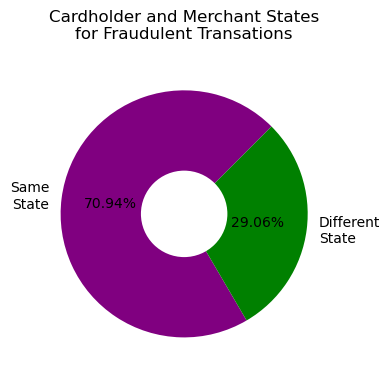

In [34]:
# Calculate the amount of fraud transactions with same state and different state.
isStateSame = clean_fraud_merchant_df["isStateSame"].value_counts()

# Create a donut chart
plt.figure(figsize=(4, 4))
plt.pie(isStateSame, labels=["Same\nState","Different\nState"], autopct='%1.2f%%', startangle=45, colors=["purple", "green"])
plt.axis("equal")
centre_circle = plt.Circle((0,0),0.35,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Cardholder and Merchant States\nfor Fraudulent Transations")
plt.tight_layout()
plt.show()

- **Analysis**: The chart shows that around 71% of the fraudulent transactions are performed with merchants located in the same State where the cardholder is located.

To take the analysis a bit further, the merchant State of fraudulent transactions was identified, but only for the top 3 Cardholder's States (New York, Pennsylvania, and Texas).

In [35]:
# Create a Data Frame with the top three cardholder States and their amount fraudulent transactions
top = clean_fraud_merchant_df.groupby("state")["trans_num"].nunique().reset_index()
top = top.sort_values(by="trans_num", ascending=False).head(3)

A bar chart was created to show the merchant States.

In [37]:
# Filter Data by the top three States and group by the merchant state
top_states = clean_fraud_merchant_df["state"].isin(top["state"])
top_states_df = clean_fraud_merchant_df[top_states][["merch_state","trans_num"]]
top_states_df = top_states_df.groupby("merch_state")["trans_num"].nunique().reset_index()
top_states_df = top_states_df.sort_values(by="trans_num", ascending=False)

# Create a bar chart with the merchant states
topbar = px.bar(top_states_df,
                x="merch_state",
                y="trans_num",
                title= "<b>Merchant State for Top 3 Cardholder States (NY, PA and TX)",
                color="merch_state",
                category_orders={"merch_state":top_states_df["merch_state"]}
)
topbar.update_yaxes(title=None)
topbar.update_xaxes(title="State")
topbar.update_layout(showlegend=False,
                         title_font_size=17,
                         title_x=0.5,
                         margin = dict(l=0,
                                       r=0,
                                       b=10,
                                       t=60,
                                       autoexpand=True
                        )
)
topbar.show()

- **Analysis**: The bar chart confirms how most of the merchants where the fraudulent transactions happened, were located either in these three States or in States next to them, such as Connecticut, West Virginia, New Jersey, Oklahoma, Ontario, and Ohio.

- **Conclusion**: The findings can help in the prediction of fraudulent transactions on how they are more likely to happen within the cardholder's state or the nearby States.